# 3D Segmentation Tutorial
In the following tutorial you'll learn a bit about volumetric segmentation of medical images using a 3D convolutional neural network. Much of the code is borrowed from https://github.com/imlab-uiip/lung-segmentation-3d.

In [1]:
import numpy as np
import nibabel as nib
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from skimage.color import hsv2rgb, rgb2hsv, gray2rgb
from scipy.misc import imresize
from skimage.color import hsv2rgb, rgb2hsv, gray2rgb
from skimage import io, exposure
from keras.models import load_model

plt.ioff()

%matplotlib inline

Using TensorFlow backend.


# NIfTI images
We can use the SimpleITK module to load NIfTI images and get the numpy representation.


Medical images can have a number of properties as shown in the figure below. (figure from insightsoftwareconsortium.github.io) 

![title](ImageOriginAndSpacing.png)

Here's an example of a reading a NIfTI image and accessing it's associated properties.

The number of dimensions are:  3
The size of the 3D image is:  (128, 128, 64)
The width is:  128
The height is:  128
The depth is:  64
The pixel spacing is:  (3.007812023162842, 3.007812023162842, 5.0)
The origin is at: (-190.99606323242188, 190.99606323242188, -157.5)
The pixel type is:  32-bit float


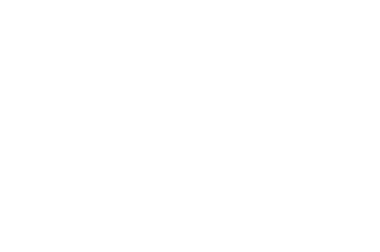

In [4]:
img3D = sitk.ReadImage('id001-128x128x64.nii.gz')

plt.axis('off')
print('The number of dimensions are: ',img3D.GetDimension())
print('The size of the 3D image is: ', img3D.GetSize())
print('The width is: ',img3D.GetWidth())
print('The height is: ', img3D.GetHeight())
print('The depth is: ', img3D.GetDepth())
print('The pixel spacing is: ', img3D.GetSpacing())
print('The origin is at:', img3D.GetOrigin())
print('The pixel type is: ', img3D.GetPixelIDTypeAsString())

# Conversion between SimpleITK to numpy

In [5]:
nimg=sitk.GetArrayFromImage(img3D)
print(nimg)

[[[-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  ...
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]]

 [[-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  ...
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]]

 [[-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  ...
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -3024. ... -3024. -3024. -3024.]]

 ...

 [[-3024. -3024. -3024. ... -3024. -3024. -3024.]
  [-3024. -3024. -30

# Indexing pixels and slicing

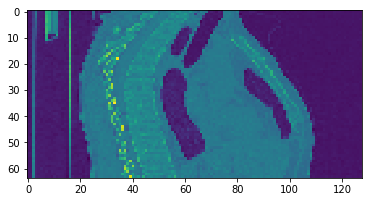

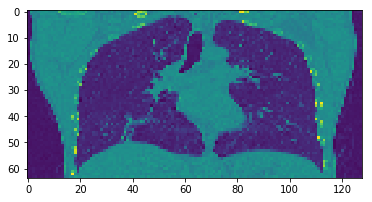

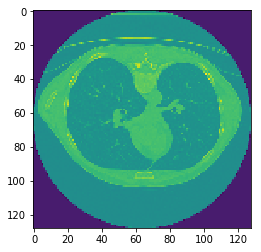

In [6]:
img_shape=img3D.GetSize()

#Saggital view. Flip z-axis
plt.imshow(sitk.GetArrayFromImage(img3D[img_shape[0]//2,:,::-1]))
plt.figure()
#Frontal view. Flip z-axis
plt.imshow(sitk.GetArrayFromImage(img3D[:,img_shape[1]//2,::-1]))
plt.figure()
#Transverse view
plt.imshow(sitk.GetArrayFromImage(img3D[:,:,img_shape[2]//2]))

# Subsampling without interpolation

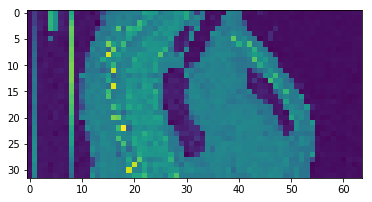

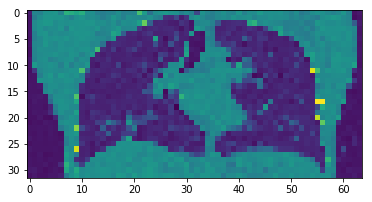

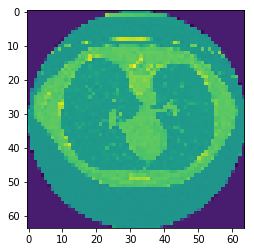

In [7]:
img3D_subsampled=img3D[::2,::2,::2]
img_shape=img3D_subsampled.GetSize()
plt.imshow(sitk.GetArrayFromImage(img3D_subsampled[img_shape[0]//2,:,::-1]))
plt.figure()
plt.imshow(sitk.GetArrayFromImage(img3D_subsampled[:,img_shape[1]//2,::-1]))
plt.figure()
plt.imshow(sitk.GetArrayFromImage(img3D_subsampled[:,:,img_shape[2]//2]))

# Flipping

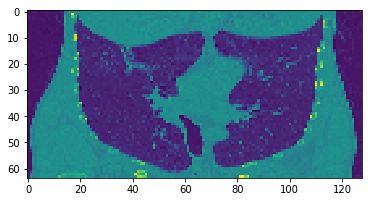

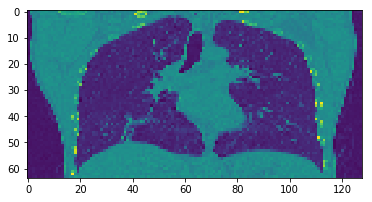

In [8]:
#Original
plt.imshow(sitk.GetArrayFromImage(img3D[:,64,:]))
plt.figure()
#Flipped
plt.imshow(sitk.GetArrayFromImage(img3D[:,64,::-1]))

# Visualizing slices from 3D image
Here's an example showing the saggital, transverse, and frontal planes of the lung. We are going to use the following helper function, myshow(), to display the results which takes into account the inter-pixel spacing to more accurately render the image.  

In [7]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[0], ysize*spacing[1], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

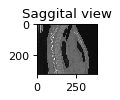

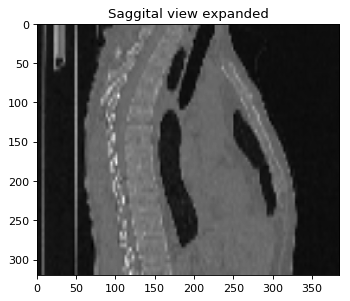

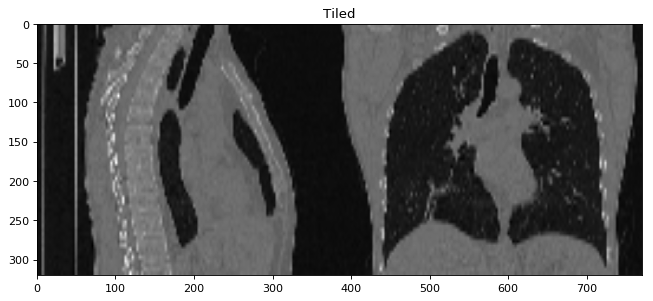

In [8]:
img_shape=img3D.GetSize()
saggital = img3D[img_shape[0]//2, :, ::-1]
frontal = img3D[:, img_shape[1]//2, ::-1]
transverse = img3D[:, :, img_shape[2]//2]
myshow(saggital, title='Saggital view')
#We can expand the saggital view
myshow(sitk.Expand(saggital,[5,5]), title='Saggital view expanded')
#We can tile the three views
slices=[saggital,frontal]
myshow(sitk.Expand(sitk.Tile(slices,[2,1]),[10,10]), title='Tiled')

# 3D U-Net model for 3D Segmentation
We're going to use the keras package to construct the [3D U-Net](https://lmb.informatik.uni-freiburg.de/Publications/2016/CABR16/) network model. The network consists of a number of encoding blocks (set of 3D convolution, non-linear, and 3D pooling layers) that successively build richer representations of the 3D input volume taking into account larger spatial context. The encoding blocks are followed a set of decoding blocks (upsampling layer followed by a set of 3D convolution and non-linear layers) that take the feature map from the previous block (either encoder or decoder block), upsample it, and concatenate the output of the corresponding encoder block that has the same spacial resolution. An example 3D U-Net architecture is shown below. 

 

 ![image.png](figureMICCAI2016small.png)
 (image borrowed from https://lmb.informatik.uni-freiburg.de/Publications/2016/CABR16/)

The following is a simple implementation of the Unet3D architecture that we will use to learn the 3D binary segmentation of the lung.

In [4]:
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Input, Convolution3D, MaxPooling3D, UpSampling3D
from keras.layers import Reshape, Activation
from keras.layers.normalization import BatchNormalization

# The UNet3D architecture consists of a set of encoding blocks, followed by a set of decoding blocks
def build_model(inp_shape, k_size=3):
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)

    #Beginning of encoding blocks
    #The input to the network is a batch of 3D images with optional pixel coordinates
    #Encoding block 1
    data = Input(shape=inp_shape)
    conv1 = Convolution3D(padding='same', filters=32, kernel_size=k_size)(data)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Convolution3D(padding='same', filters=32, kernel_size=k_size)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    #Encoding block 2
    conv3 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(pool1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv4 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    #Encoding block 3
    conv5 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(pool2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv6 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv6)

    #Encoding block 4
    conv7 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(pool3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv8 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv8)

    #Encoding block 5
    conv9 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(pool4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    #Beginning of decoding blocks
    up1 = UpSampling3D(size=(2, 2, 2))(conv9)
    conv10 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(up1)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    conv11 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(conv10)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    #Skip connection from encoding block 4
    merged1 = concatenate([conv11, conv8], axis=merge_axis)
    conv12 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(merged1)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation('relu')(conv12)

    up2 = UpSampling3D(size=(2, 2, 2))(conv12)
    conv13 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up2)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    conv14 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation('relu')(conv14)
    #Skip connection from encoding block 3
    merged2 = concatenate([conv14, conv6], axis=merge_axis)
    conv15 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged2)
    conv15 = BatchNormalization()(conv15)
    conv15 = Activation('relu')(conv15)

    up3 = UpSampling3D(size=(2, 2, 2))(conv15)
    conv16 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up3)
    conv16 = BatchNormalization()(conv16)
    conv16 = Activation('relu')(conv16)
    conv17 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv16)
    conv17 = BatchNormalization()(conv17)
    conv17 = Activation('relu')(conv17)
    #Skip connection from encoding block 2
    merged3 = concatenate([conv17, conv4], axis=merge_axis)
    conv18 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged3)
    conv18 = BatchNormalization()(conv18)
    conv18 = Activation('relu')(conv18)

    up4 = UpSampling3D(size=(2, 2, 2))(conv18)
    conv19 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up4)
    conv19 = BatchNormalization()(conv19)
    conv19 = Activation('relu')(conv19)
    conv20 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv19)
    conv20 = BatchNormalization()(conv20)
    conv20 = Activation('relu')(conv20)
    #Skip connection form encoding block 1
    merged4 = concatenate([conv20, conv2], axis=merge_axis)
    conv21 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged4)
    conv21 = BatchNormalization()(conv21)
    conv21 = Activation('relu')(conv21)

    conv22 = Convolution3D(padding='same', filters=2, kernel_size=k_size)(conv21)
    #Network output is binary segmentation label
    output = Reshape([-1, 2])(conv22)
    output = Activation('softmax')(output)
    output = Reshape(inp_shape[:-1] + (2,))(output)

    model = Model(data, output)
    return model


Using TensorFlow backend.


# Loading image data
The function below constructs the input, $\bf{X}$, to the network which consists of the 3D images of the lung concatenated with the $x$, $y$, and $z$ pixel coordinates. The network output is a binary 3D segmentation that is compared against the ground truth binary label, $\bf{y}$.

In [26]:
def loadDataGeneral(df, path):
    """
    This function loads data stored in nifti format. Data should already be of
    appropriate shape.
    
    Inputs:
    - df: Pandas dataframe with two columns: image filenames and ground truth filenames.
    - path: Path to folder containing filenames from df.
    - append_coords: Whether to append coordinate channels or not.
    Returns:
    - X: Array of 3D images with 1 or 4 channels depending on `append_coords`.
    - y: Array of 3D masks with 1 channel.
    """
    X, y = [], []
    for i, item in df.iterrows():
        img = nib.load(path + item[0]).get_data()
        mask = nib.load(path + item[1]).get_data()
        mask = np.clip(mask, 0, 255)
        cmask = (mask * 1. // 255)
        out = cmask
        X.append(img)
        y.append(out)
    X = np.expand_dims(X, -1)
    y = np.expand_dims(y, -1)
    y = np.concatenate((1 - y, y), -1)
    y = np.array(y)
    # Append coordinates as additional channels
    n = X.shape[0]
    inpShape = X.shape[1:]
    xx = np.empty(inpShape)
    for i in range(inpShape[1]):
        xx[:, i, :, 0] = i
    yy = np.empty(inpShape)
    for i in range(inpShape[0]):
        yy[i, :, :, 0] = i
    zz = np.empty(inpShape)
    for i in range(inpShape[2]):
        zz[:, :, i, 0] = i
    X = np.concatenate([X, np.array([xx] * n), np.array([yy] * n), np.array([zz] * n)], -1)

    print('### Dataset loaded')
    print('\t{}'.format(path))
    print( '\t{}\t{}'.format(X.shape, y.shape))
    print( '\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    return X, y


# Model training


We will use stochastic gradient descent (specifically the Adam update rule) to train the network we built earlier, to minimize the binary cross entropy loss $\frac{1}{N}\sum\limits_{i=1}^N(y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)$.



### Dataset loaded
	./
	(4, 128, 128, 64, 4)	(4, 128, 128, 64, 2)
	X:-3603.9-2204.6	y:-0.0-1.0

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 64, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 64, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64, 128         conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64, 0           batch_normalization_1[0][0]      
_____________

Train on 3 samples, validate on 1 samples
Epoch 1/10
3/3 [==============================] - 23s 8s/step - loss: 0.5150 - acc: 0.7593 - val_loss: 1.7870 - val_acc: 0.8892
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 0.1535 - acc: 0.9338 - val_loss: 1.7509 - val_acc: 0.8740
Epoch 3/10
3/3 [==============================] - 5s 2s/step - loss: 0.0853 - acc: 0.9644 - val_loss: 1.5792 - val_acc: 0.8600
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 0.0796 - acc: 0.9632 - val_loss: 0.7452 - val_acc: 0.8770
Epoch 5/10
3/3 [==============================] - 5s 2s/step - loss: 0.0733 - acc: 0.9655 - val_loss: 0.6429 - val_acc: 0.8554
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 0.0698 - acc: 0.9665 - val_loss: 0.8797 - val_acc: 0.8353
Epoch 7/10
3/3 [==============================] - 5s 2s/step - loss: 0.0702 - acc: 0.9658 - val_loss: 1.1861 - val_acc: 0.8112
Epoch 8/10
3/3 [==============================] - 5s 2s/step - loss:

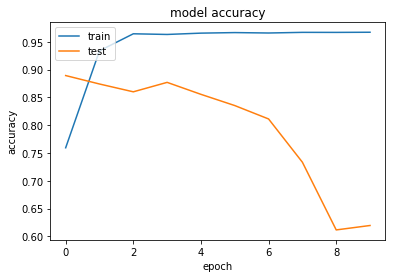

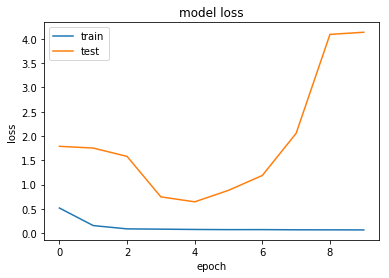

In [17]:
from keras.callbacks import ModelCheckpoint
# Path to csv-file. File should contain X-ray filenames as first column,
# mask filenames as second column.
csv_path = './idx-train.csv'
# Path to the folder with images. Images will be read from path + path_from_csv
path = csv_path[:csv_path.rfind('/')] + '/'

df = pd.read_csv(csv_path)
# Shuffle rows in dataframe. Random state is set for reproducibility.
df = df.sample(frac=1, random_state=23)

# Load training data
X, y = loadDataGeneral(df, path)

# Build model
inp_shape = X[0].shape
model = build_model(inp_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

##########################################################################################
checkpointer = ModelCheckpoint('model3.{epoch:03d}.hdf5', period=5)

history=model.fit(X, y, batch_size=1, epochs=10, callbacks=[checkpointer], validation_split=0.2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Segmentation task accuracy

In order to evaluate the quality of the predicted binary segmentation, with respect to the ground truth segmentation,  we will use the Intersection over Union accuracy, otherwise known as the Jaccard index. If $P$ and $G$ are the sets of foreground pixels in the predicted and ground truth segmentation respectively, then the Intersection over Union accuracy can be computed as, $\frac{|P \cap G|}{|P\cup G|}$.

In [6]:
def IoU(y_true, y_pred):
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

# Dice coefficient

Another measure of overlap between two sets is the Dice coefficient, which is commonly used in medical images. The dice coefficient can be written as $DC=\frac{2|P \cap G|}{|P|+|G|}$, and similar to the IoU accuracy in segmentation, measures the amount of agreement between to segmentation masks. Fill in the function below for the dice coefficient.

In [ ]:
def Dice(y_true, y_pred):
    assert y_true.dtype == bool and y_pred.dtype == bool
    #fill in the rest of the function
    pass
        

# Hausdorff distance
Yet another commonly used measure of agreement between two segmentation masks is the Hausdorff distance. It is defined as $H(P,G)=\max\{h(P,G),h(G,P)\}$, where $h(P,G)=\max\limits_{p\in P}\min\limits_{g\in G} ||p-g||$, and $||\cdot||$ is the Euclidean distance.

The function $h(P,G)$ is the directed Hausdorff distance from $P$ to $G$ and finds the distance of the point in $P$ that is furthest from its closest point in $G$. 

Finish the implementation of the Hausdorff distance function below.

In [ ]:
def Hausdorff(y_true, y_pred):
    assert y_true.dtype == bool and y_pred.dtype == bool
    #fill in the rest of the function
    pass

# Inference on held out images
- here we are loading a pre-trained model but in the following you are going to put everything together and train your own model


### Dataset loaded
	./
	(4, 128, 128, 64, 1)	(4, 128, 128, 64, 2)
	X:-3603.9-2204.6	y:-0.0-1.0



/pylon5/ac5616p/pyadolla/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
/pylon5/ac5616p/pyadolla/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/pylon5/ac5616p/pyadolla/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/pylon5/ac5616p/pyadolla/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWa

id001-128x128x64.nii.gz 0.7564289644283904
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
id002-128x128x64.nii.gz 0.632878241456294
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
id003-128x128x64.nii.gz 0.7684436870065373
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
id004-128x128x64.nii.gz 0.7504531917648583
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
Mean IoU:
0.72705102116402


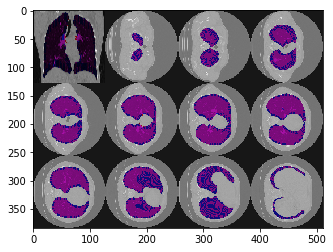

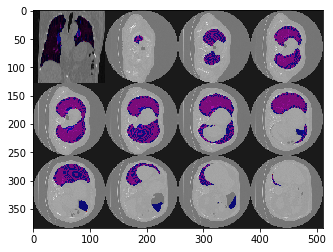

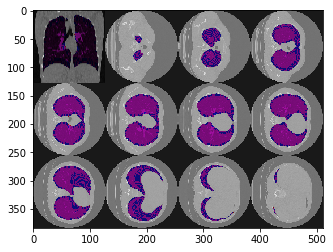

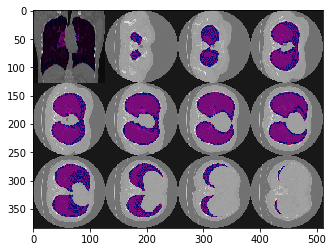

In [28]:
def saggital(img):
    print(img.shape)
    """Extracts midle layer in saggital axis and rotates it appropriately."""
    return img[:, img.shape[1] // 2, ::-1].T

img_size = 128


# Path to csv-file. File should contain X-ray filenames as first column,
# mask filenames as second column.
csv_val_path = './idx-val.csv'
# Path to the folder with images. Images will be read from path + path_from_csv
val_path = csv_val_path[:csv_val_path.rfind('/')] + '/'

df_val = pd.read_csv(csv_val_path)

# Load test data
append_coords = True 
Xval, yval = loadDataGeneral(df_val, val_path)

n_val = Xval.shape[0]
inpShape_val = Xval.shape[1:]

model = load_model('trained_model.hdf5')
# Predict on test data
pred = model.predict(Xval, batch_size=1)[..., 1]

# Compute scores and visualize
ious = np.zeros(n_val)
for i in range(n_val):
    gt = yval[i, :, :, :, 1] > 0.5 # ground truth binary mask
    pr = pred[i] > 0.5 # binary prediction

    # Compute scores
    ious[i] = IoU(gt, pr)
    print(df_val.ix[i]['path'], ious[i])

    # Rescaling images to be within [0, 1].
    t_img = exposure.rescale_intensity(nib.load(val_path + df_val.ix[i]['path']).get_data(), out_range=(0, 1))
    # Creating 3x4 table previews
    lungs = np.zeros((img_size * 3, img_size * 4)) # Slices from original grayscale image
    mask = np.zeros((img_size * 3, img_size * 4)) # Slices from predicted mask
    gt_mask = np.zeros((img_size * 3, img_size * 4)) # Slices from ground truth mask
    # Fill [0, 0] cell with saggital view of lungs
    lungs[:img_size, :img_size] = imresize(saggital(t_img), [img_size, img_size]) * 1. / 256
    mask[:img_size, :img_size][imresize(saggital(pred[i]), [img_size, img_size]) > 128] = 1
    gt_mask[:img_size, :img_size][imresize(saggital(yval[i][..., 1]), [img_size, img_size]) > 128] = 1
    # Fill the rest of the cells with 11 slices in z direction
    for k in range(1, 12):
        yy, xx = k // 4, k % 4 # Cell coordinates
        zz = int(t_img.shape[-1] * (k * 1. / 12)) # z coordinate of a slice
        lungs[yy * img_size: (yy + 1) * img_size, xx * img_size: (xx + 1) * img_size] = t_img[:, :, -zz]
        mask[yy * img_size: (yy + 1) * img_size, xx * img_size: (xx + 1) * img_size][pr[:, :, -zz]] = 1
        gt_mask[yy * img_size: (yy + 1) * img_size, xx * img_size: (xx + 1) * img_size][gt[:, :, -zz]] = 1
    # Combining masks to get a pretty picture
    prv = rgb2hsv(gray2rgb(lungs))
    mask_hsv = rgb2hsv(np.dstack([gt_mask, np.zeros_like(mask), mask]))
    prv[..., 0] = mask_hsv[..., 0]
    prv[..., 1] = mask_hsv[..., 1] * 0.9
    plt.figure()
    plt.imshow(hsv2rgb(prv))
#    io.imsave('Demo/Predictions/' + df.ix[i]['path'] + '-preview2.png', hsv2rgb(prv))
#    io.imsave('Demo/Predictions/' + df.ix[i]['path'] + '-mask2.png', np.dstack([gt_mask, mask, mask]))


print( 'Mean IoU:')
print( ious.mean())

